# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


## Question 1

(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

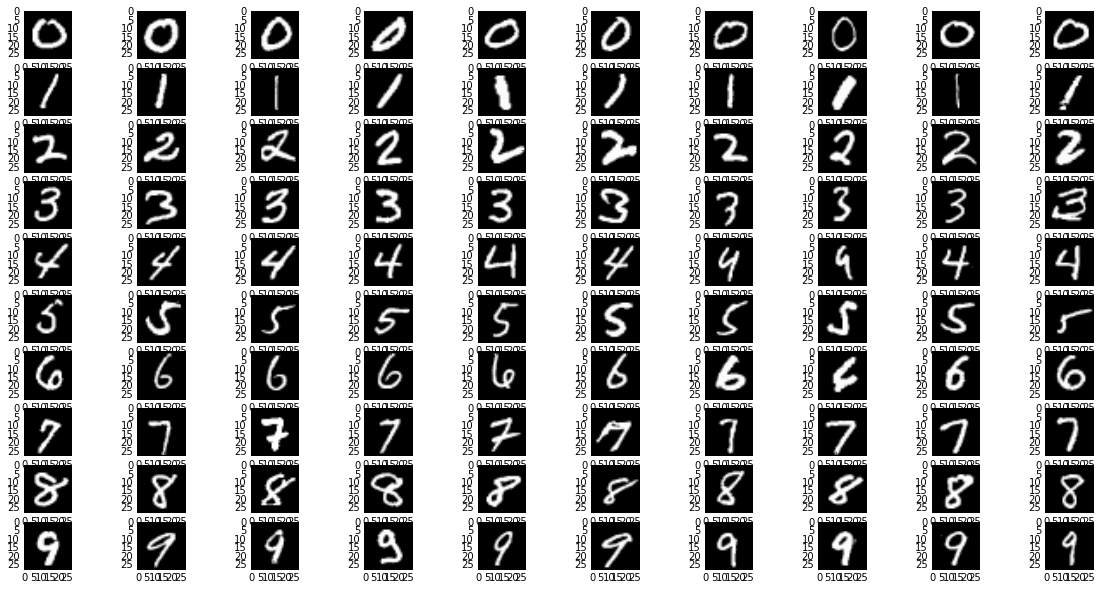

In [3]:
#def P1(num_examples=10):

### STUDENT START ###

# Creating an array with 10 examples of each digit from the mini train data
digits = np.zeros((100, 784))
for d in range(0, 10):
    each_digit = mini_train_data[mini_train_labels == d]
    digits[d*10:(d+1)*10] = each_digit[0:10]

# Visualizing the examples in 10x10 grid 
plt.rc('font', family = 'sans-serif')
plt.rc('image', cmap = 'gray') #or jet
plt.figure(figsize=(20,10))

for i in range(0, 100):
    plt.subplot(10, 10, i + 1) #creates the 10x10 grid
    digits_to_plot = digits[i,].reshape((28,28)) #reshape data to 28x28 matrix
    plt.imshow(digits_to_plot)
plt.show()

### STUDENT END ###

#P1(10)

## Question 2

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
#def P2(k_values):

### STUDENT START ###

# Getting the accuracy of a K-Nearest-Neighbors model with k = [1,3,5,7,9]
k_values = [1, 3, 5, 7, 9]

for k in k_values:
    kn = KNeighborsClassifier(n_neighbors = k)
    kn.fit(mini_train_data, mini_train_labels)
    print 'For k=%d accuracy: %3.2f' %(k, kn.score(dev_data, dev_labels))

For k=1 accuracy: 0.89
For k=3 accuracy: 0.88
For k=5 accuracy: 0.87
For k=7 accuracy: 0.86
For k=9 accuracy: 0.86


In [5]:
# For k = 1 get precision, recall and F1 for each label
kn = KNeighborsClassifier(n_neighbors = 1)
kn.fit(mini_train_data, mini_train_labels)
predicted_labels = kn.predict(dev_data)
print(classification_report(dev_labels, predicted_labels))
    
### STUDENT END ###

#k_values = [1, 3, 5, 7, 9]
#P2(k_values)

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000



ANSWER: Most difficult digit seems to be 9

## Question 3

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [6]:
#def P3(train_sizes, accuracies):

### STUDENT START ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
time_per_size = []

# Get accuracy and time of the K-Nearest-Neighbors for each different training sizes
for t in train_sizes:
    t_start = time.time()
    train_data_resized, train_labels_resized = train_data[:t], train_labels[:t]
    kn = KNeighborsClassifier(n_neighbors = 1)
    kn.fit(train_data_resized, train_labels_resized)
    t_stop = time.time()
    t_duration = t_stop - t_start
    accuracies.append(kn.score(dev_data, dev_labels))
    time_per_size.append(t_duration)
    print 'For train_size=%d, time=%3.4f accuracy: %3.2f' %(t, t_duration, kn.score(dev_data, dev_labels))
    
### STUDENT END ###

#train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
#accuracies = []
#P3(train_sizes, accuracies)

For train_size=100, time=0.0014 accuracy: 0.72
For train_size=200, time=0.0016 accuracy: 0.79
For train_size=400, time=0.0044 accuracy: 0.84
For train_size=800, time=0.0115 accuracy: 0.88
For train_size=1600, time=0.0243 accuracy: 0.90
For train_size=3200, time=0.0864 accuracy: 0.93
For train_size=6400, time=0.2431 accuracy: 0.94
For train_size=12800, time=0.8326 accuracy: 0.96
For train_size=25000, time=3.8945 accuracy: 0.97


## Question 4

(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Accuracy predicted for n = 60000 is 1.243
Variance score: 0.443
Residual sum of squares: 0.0035


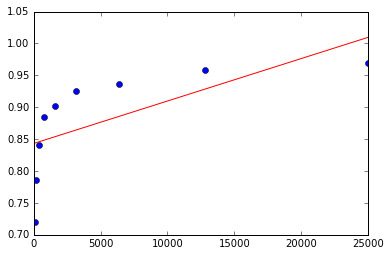

In [7]:
### def P4():

### STUDENT START ###

#Change lists into np arrays3
train_sizes_array = np.transpose([train_sizes])
accuracies_array = np.transpose([accuracies])

#Fit the linear regression
lr = LinearRegression(fit_intercept=True)
lr.fit(train_sizes_array, accuracies_array)
print 'Accuracy predicted for n = 60000 is %.3f' % (lr.coef_ * 60000 + lr.intercept_)
#Getting the R-square for this model
print('Variance score: %.3f' % lr.score(train_sizes_array, accuracies_array))
# The mean square error
print("Residual sum of squares: %.4f" % np.mean((lr.predict(train_sizes_array) - accuracies_array) ** 2))

plt.plot(train_sizes, accuracies, 'bo', label='line 1', linewidth=2)
plt.plot(train_sizes_array, lr.predict(train_sizes_array),color='red')
#plt.plot(Xt, approx_function(Xt))
plt.show()

### STUDENT END ###

#P4()

Accuracy predicted for n = 60000 is 0.955
Variance score: 0.991
Residual sum of squares: 0.0001


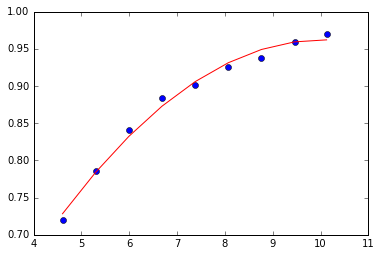

In [9]:
# Transformation that makes the prediction more reasonnable - log scale for train_sizes and adding a polynomial feature

train_sizes_array = np.transpose([np.log(train_sizes)])
train_sizes_array2 = np.concatenate((train_sizes_array, train_sizes_array**2), axis=1)
#train_sizes_array = np.transpose([np.log(train_sizes)])
accuracies_array = np.transpose([accuracies])

#Fit the linear regression
lr = LinearRegression(fit_intercept=True)
lr.fit(train_sizes_array2, accuracies_array)
print 'Accuracy predicted for n = 60000 is %.3f' % (lr.coef_[0][0] * np.log(60000) + lr.coef_[0][1] * np.log(60000)**2 + lr.intercept_)
#Getting the R-square for this model
print('Variance score: %.3f' % lr.score(train_sizes_array2, accuracies_array))
# The mean square error
print("Residual sum of squares: %.4f" % np.mean((lr.predict(train_sizes_array2) - accuracies_array) ** 2))

plt.plot(train_sizes_array, accuracies_array, 'bo', label='line 1', linewidth=2)
plt.plot(train_sizes_array, lr.predict(train_sizes_array2),color='red')
#plt.plot(Xt, approx_function(Xt))
plt.show()


ANSWER: The issue here is that the relationship between train_sizes and accuracies is not linear, thus we get a predicted value for n = 60000 that is > 1

## Question 5

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [10]:
#def P5():

### STUDENT START ###
# For k = 1 get precision, recall and F1 for each label
kn = KNeighborsClassifier(n_neighbors = 1)
kn.fit(train_data, train_labels)
predicted_labels = kn.predict(dev_data)
#print(classification_report(dev_labels, predicted_labels))
confusion_matrix(dev_labels, predicted_labels)
    
### STUDENT END ###

#P5()

array([[ 99,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 105,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0,  98,   2,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0,  83,   0,   1,   0,   0,   1,   1],
       [  0,   0,   0,   0, 102,   0,   0,   0,   0,   2],
       [  1,   0,   0,   0,   0,  88,   0,   0,   1,   1],
       [  1,   0,   0,   0,   1,   0,  96,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0, 111,   0,   1],
       [  1,   0,   1,   2,   0,   2,   1,   0,  89,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 106]])

Example of mistakes would be pairs: (4,9) (2,3)

## Question 6

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [45]:
#def P6():

#Creating the blur filters and applying it to the data set

def blurring(digits_to_plot):
    digits_to_plot = digits_to_plot.reshape((28,28))
    digits_blurred = np.zeros((28, 28))
    for i in range(0, 27):
        for j in range(0, 27):
            digits_blurred[i,j] = digits_to_plot[i - 1,j - 1] + digits_to_plot[i - 1,j] + digits_to_plot[i - 1,j + 1] + digits_to_plot[i,j + 1] + digits_to_plot[i + 1,j + 1] + digits_to_plot[i + 1,j] + digits_to_plot[i + 1,j -1] + digits_to_plot[i,j - 1]        
    i = 27
    for j in range(0, 27):
            digits_blurred[i,j] = digits_to_plot[i - 1,j - 1] + digits_to_plot[i - 1,j] + digits_to_plot[i - 1,j + 1] + digits_to_plot[i,j + 1]+ digits_to_plot[i,j - 1]        
    j = 27
    for i in range(0, 27):
            digits_blurred[i,j] = digits_to_plot[i - 1,j - 1] + digits_to_plot[i - 1,j] + digits_to_plot[i + 1,j] + digits_to_plot[i + 1,j -1] + digits_to_plot[i,j - 1]        
    i, j = 27, 27
    digits_blurred[i,j] = digits_to_plot[i - 1,j - 1] + digits_to_plot[i - 1,j] + digits_to_plot[i,j - 1]
    return(digits_blurred.ravel())

train_data_blurred = [blurring(digits_to_plot) for digits_to_plot in train_data]
dev_data_blurred = [blurring(digits_to_plot) for digits_to_plot in dev_data]

In [46]:
#Running the different blur filters

kn = KNeighborsClassifier(n_neighbors = 1)
kn.fit(train_data_blurred, train_labels)
predicted_labels = kn.predict(dev_data)
print 'preprocessed train_data but not dev_data accuracy: %3.2f' %(kn.score(dev_data, dev_labels))

kn = KNeighborsClassifier(n_neighbors = 1)
kn.fit(train_data, train_labels)
predicted_labels = kn.predict(dev_data_blurred)
print 'preprocessed dev_data but not train_data accuracy: %3.2f' %(kn.score(dev_data_blurred, dev_labels))

kn = KNeighborsClassifier(n_neighbors = 1)
kn.fit(train_data_blurred, train_labels)
predicted_labels = kn.predict(dev_data_blurred)
print 'preprocessed train_data and preprocessed dev_data accuracy: %3.2f' %(kn.score(dev_data_blurred, dev_labels))

### STUDENT END ###

#P6()

preprocessed train_data but not dev_data accuracy: 0.16
preprocessed dev_data but not train_data accuracy: 0.75
preprocessed train_data and preprocessed dev_data accuracy: 0.98


ANSWER:

## Question 7

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [92]:
#def P7():

### STUDENT START ###

# Run the BernouilliNB with binary mapping
ber = BernoulliNB(binarize = 0.5)
ber.fit(train_data, train_labels)
print 'bernouilli accuracy: %3.3f' %ber.score(dev_data, dev_labels)

bernouilli accuracy: 0.837


In [95]:
#Mapping the pixel values to 0,1 & 2

train_data_multibin = np.zeros(train_data.shape)

def multi_bin(digit):
    if digit < 0.3:
        return(0)
    if digit > 0.7:
        return(2)
    else:
        return(1)

for rows in range(0, train_data.shape[0]):
    train_data_multibin[rows] = [multi_bin(digit) for digit in train_data[rows]]
    
print(train_data_multibin[0])

# Test the results of the mapping for parameters tweaking
#digits_to_plot = mini_train_data_multibin[0].reshape((28,28)) #reshape data to 28x28 matrix
#plt.imshow(digits_to_plot)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  2.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  2.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  2.  1.  0.  0.  0.  0.  0.  0.  0.  0

In [96]:
# Run the MultinomialNB with new mapping

mul = MultinomialNB()
mul.fit(train_data_multibin, train_labels)
print 'multinomial accuracy: %3.3f' %mul.score(dev_data, dev_labels)

### STUDENT END ###

#P7()

multinomial accuracy: 0.830


(array([ 38457128.,    385050.,    318014.,    252619.,    261952.,
           251055.,    242321.,    194805.,    233049.,    212454.,
           283585.,    236039.,    204963.,    248801.,    265905.,
           252475.,    282577.,    327917.,    402147.,   3727144.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]),
 <a list of 20 Patch objects>)

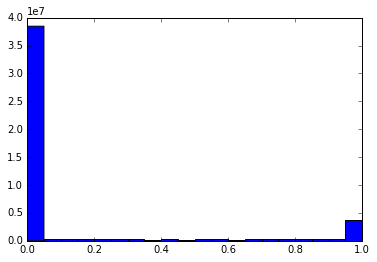

In [102]:
# Get histogram of distribution of the data

plt.hist(train_data.ravel(), 20)

ANSWER: The multiclass classifier does not improve the accuracy of the classifier, because the data has a bimodal distribution as seen on the histogram

## Question 8

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [122]:
#def P8(alphas):

### STUDENT START ###

alphas = {'alpha':[0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
ber = BernoulliNB(binarize = 0.5)
clf = GridSearchCV(ber, alphas)
clf.fit(train_data, train_labels)

### STUDENT END ###

#nb = P8(alphas)

GridSearchCV(cv=None, error_score='raise',
       estimator=BernoulliNB(alpha=1.0, binarize=0.5, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [124]:
for a in alphas['alpha']:
    ber = BernoulliNB(binarize = 0.5, alpha = a)
    ber.fit(train_data, train_labels)
    print 'bernouilli with alpha %.4f accuracy: %3.4f' %(a, ber.score(dev_data, dev_labels))


bernouilli with alpha 0.0000 accuracy: 0.0910
bernouilli with alpha 0.0001 accuracy: 0.8400
bernouilli with alpha 0.0010 accuracy: 0.8390
bernouilli with alpha 0.0100 accuracy: 0.8390
bernouilli with alpha 0.1000 accuracy: 0.8380
bernouilli with alpha 0.5000 accuracy: 0.8380
bernouilli with alpha 1.0000 accuracy: 0.8370
bernouilli with alpha 2.0000 accuracy: 0.8370
bernouilli with alpha 10.0000 accuracy: 0.8350


In [135]:
#print nb.best_params_

ANSWER: Accuracy is really low when no smoothing is applied (alpha = 0) - it is to be expected

## Question 9 

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [45]:
#def P9():

### STUDENT END ###
gau = GaussianNB()
gau.fit(train_data, train_labels)

gau.sigma_ = np.full(gau.sigma_.shape, 0.2)

print 'gaussian accuracy: %3.2f' %gau.score(dev_data, dev_labels)

#digits_to_plot = gau.sigma_[0].reshape((28,28)) #reshape data to 28x28 matrix
#plt.imshow(digits_to_plot)

### STUDENT END ###

#gnb = P9()

gaussian accuracy: 0.81


ANSWER: Naive bayes assumption look at each pixel and multiply probabilities. Because of that effect (and presence of many 0s) the variance (sigma) tends to be too small, so anything slightly different from the mean will be classified wrongly. We are increasing the variance to an set threshold to compensate for that effect and get an increase in accuracy to 0.81

## Question 10

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

20


'"\ndigits = np.zeros((100, 784))\nfor d in range(0, 10):\n    each_digit = mini_train_data[mini_train_labels == d]\n    digits[d*10:(d+1)*10] = each_digit[0:10]\n\n# Visualizing the examples in 10x10 grid \nplt.rc(\'font\', family = \'sans-serif\')\nplt.rc(\'image\', cmap = \'gray\') #or jet\nplt.figure(figsize=(20,10))\n\nfor i in range(0, 100):\n    plt.subplot(10, 10, i + 1) #creates the 10x10 grid\n    digits_to_plot = digits[i,].reshape((28,28)) #reshape data to 28x28 matrix\n    plt.imshow(digits_to_plot)\nplt.show()\n'

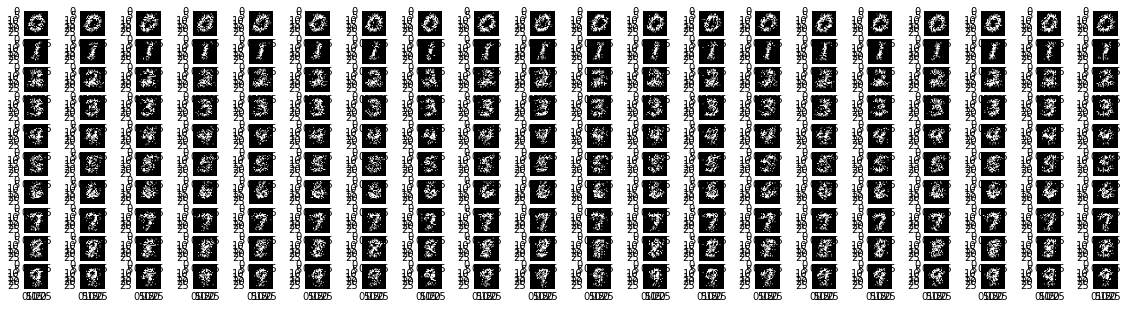

In [76]:
#def P10(num_examples):

### STUDENT START ###

# Prepare the data set
ber = BernoulliNB(binarize = 0.5)
ber.fit(train_data, train_labels)

digits_prob = np.exp(ber.feature_log_prob_)

random_prob = np.random.rand(20, 784)

digits_pix = np.zeros((200, 784))
for j in range(0, 10):
    for i in range(0, random_prob.shape[0]):
        digits_pix[i + j * 20] = digits_prob[j] > random_prob[i]


# Plot the digits
plt.rc('font', family = 'sans-serif')
plt.rc('image', cmap = 'gray') #or jet
plt.figure(figsize=(20,10))

for i in range(0, 200):
    plt.subplot(20, 20, i + 1) #creates the 10x10 grid
    digits_to_plot = digits_pix[i].reshape((28,28)) #reshape data to 28x28 matrix
    plt.imshow(digits_to_plot)

### STUDENT END ###

#P10(20)

ANSWER:

## Question 11

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [123]:
dev_labels.shape

(1000,)

In [129]:
#def P11(buckets, correct, total):
    
### STUDENT START ###
ber = BernoulliNB(binarize = 0.5)
ber.fit(train_data, train_labels)

probas_predict = np.zeros(dev_data.shape[0])
corrects = np.zeros(dev_data.shape[0])

for i in range (0, dev_data.shape[0]):
    proba_predict = ber.predict_proba(dev_data)
    index = proba_predict[i].argmax()
    probas_predict[i] = (proba_predict[i, index])
    if index == dev_labels[i]: 
        corrects[i] = 1
    else: 
        corrects[i] = 0

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
array_bins = np.digitize(probas_predict, buckets)

total = np.bincount(array_bins)
#print total.shape
#print corrects.shape
#print array_bins.shape

correct = np.bincount(array_bins, weights = corrects)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)
    
### STUDENT END ###

p(pred) <= 0.5000000000000    total =   3    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  42    accuracy = 0.524
p(pred) <= 0.9990000000000    total = 101    accuracy = 0.515
p(pred) <= 0.9999900000000    total =  74    accuracy = 0.635
p(pred) <= 0.9999999000000    total =  63    accuracy = 0.698
p(pred) <= 0.9999999990000    total =  70    accuracy = 0.871
p(pred) <= 0.9999999999900    total =  76    accuracy = 0.895
p(pred) <= 0.9999999999999    total =  85    accuracy = 0.929
p(pred) <= 1.0000000000000    total =  24    accuracy = 0.875


ANSWER: Flawed model assumptions (e.g. independence in a Naive Bayes Model) Naive Bayes tends to push probabilities toward the extremes of 0 and 1.


(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [139]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()